In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
words = open('../names.txt', 'r').read().splitlines()

chrs = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [33]:
# parameters
vocab_size = len(itos)
block_size = 5
batch_size = 32
g = torch.Generator().manual_seed(1337)
n_embd = 10
n_hidden = 100
C = torch.randn((vocab_size, n_embd), generator=g)

In [34]:
# build dataset

def build_dataset(words, block_size=block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.size(), Y.size())
    return X, Y

random.seed(1337)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)
        

torch.Size([182552, 5]) torch.Size([182552])
torch.Size([22737, 5]) torch.Size([22737])
torch.Size([22857, 5]) torch.Size([22857])


In [35]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)  #stdev 
        self.beta = torch.zeros(dim)  #mean
        # memory storage for re-production
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the memoru
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean * self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var * self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [36]:
# model construct
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    layers[-1].gamma *= 0.1  #output layer 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1  #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

49024


- `The Kaiming (He) initialization` for ReLU-like nonlinearities sometimes recommends scaling by sqrt(5/3)^2 ≈ 2.78 when using tanh or similar.

In [37]:
# Optimization
max_steps = 70000
lossi = []
ud = []  # update-to-data ratio statistics
best_val_loss = float('inf')
best_weights = None

for step in range(max_steps):

    # mini batch
    b_ix = torch.randint(0, Xtr.size(0), (batch_size,), generator=g)
    Xb, Yb = Xtr[b_ix], Ytr[b_ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(-1, n_embd * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.3 if step < 10000 else 0.2
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if step % 1000 == 0:
        

        val_loss = 0.0
        with torch.no_grad():
            # emb = C[Xval]
            # x = emb.view(-1, n_embd * block_size)
            # for layer in layers:
            #     x = layer(x)
            # val_loss += F.cross_entropy(x, Yval, reduction='sum').item()

            for i in range(0, Xval.size(0), batch_size):
                batch_X = Xval[i:i+batch_size]
                batch_Y = Yval[i:i+batch_size]
                emb = C[batch_X]
                x = emb.view(-1, n_embd * block_size)
                for layer in layers:
                    x = layer(x)
                val_loss += F.cross_entropy(x, batch_Y, reduction='sum').item()
        
        val_loss /= Xval.size(0)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = [p.data.clone() for p in parameters]
            torch.save({
                'step': step,
                'val_loss': best_val_loss,
                'weights': best_weights
            }, 'best_model.pth')
            print(f"✅ New best val loss: {best_val_loss:.4f} at step {step}")
        
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f}: lr={lr} | valuation loss {val_loss:.4f}")

    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    # break
    # if step > 1000:
    #     break


✅ New best val loss: 3.2918 at step 0
      0/  70000: 3.2830: lr=0.3 | valuation loss 3.2918
✅ New best val loss: 2.4815 at step 1000
   1000/  70000: 2.7577: lr=0.3 | valuation loss 2.4815
✅ New best val loss: 2.4049 at step 2000
   2000/  70000: 2.3358: lr=0.3 | valuation loss 2.4049
✅ New best val loss: 2.3557 at step 3000
   3000/  70000: 2.4884: lr=0.3 | valuation loss 2.3557
✅ New best val loss: 2.3183 at step 4000
   4000/  70000: 2.3414: lr=0.3 | valuation loss 2.3183
✅ New best val loss: 2.2933 at step 5000
   5000/  70000: 1.7243: lr=0.3 | valuation loss 2.2933
✅ New best val loss: 2.2763 at step 6000
   6000/  70000: 2.0515: lr=0.3 | valuation loss 2.2763
✅ New best val loss: 2.2684 at step 7000
   7000/  70000: 2.2584: lr=0.3 | valuation loss 2.2684
✅ New best val loss: 2.2483 at step 8000
   8000/  70000: 2.2937: lr=0.3 | valuation loss 2.2483
✅ New best val loss: 2.2422 at step 9000
   9000/  70000: 2.0550: lr=0.3 | valuation loss 2.2422
✅ New best val loss: 2.2376 at st

layer 2 {10Tanh}: mean +0.02, std 0.60, satured:  5%
layer 5 {10Tanh}: mean +0.00, std 0.64, satured:  7%
layer 8 {10Tanh}: mean -0.00, std 0.66, satured:  7%
layer 11 {10Tanh}: mean +0.02, std 0.66, satured:  6%
layer 14 {10Tanh}: mean +0.05, std 0.69, satured:  9%


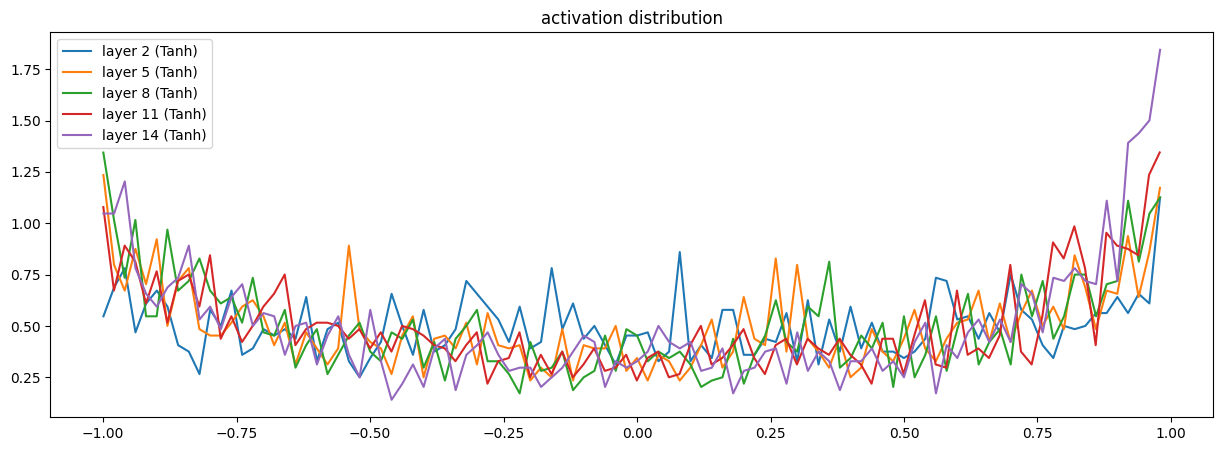

In [38]:
plt.figure(figsize=(15,5))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d {10%s}: mean %+.2f, std %.2f, satured: %2.f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.000000, std 6.355674e-03
layer 5 (      Tanh): mean +0.000000, std 5.169361e-03
layer 8 (      Tanh): mean +0.000000, std 4.931549e-03
layer 11 (      Tanh): mean -0.000000, std 4.582724e-03
layer 14 (      Tanh): mean -0.000000, std 4.977626e-03


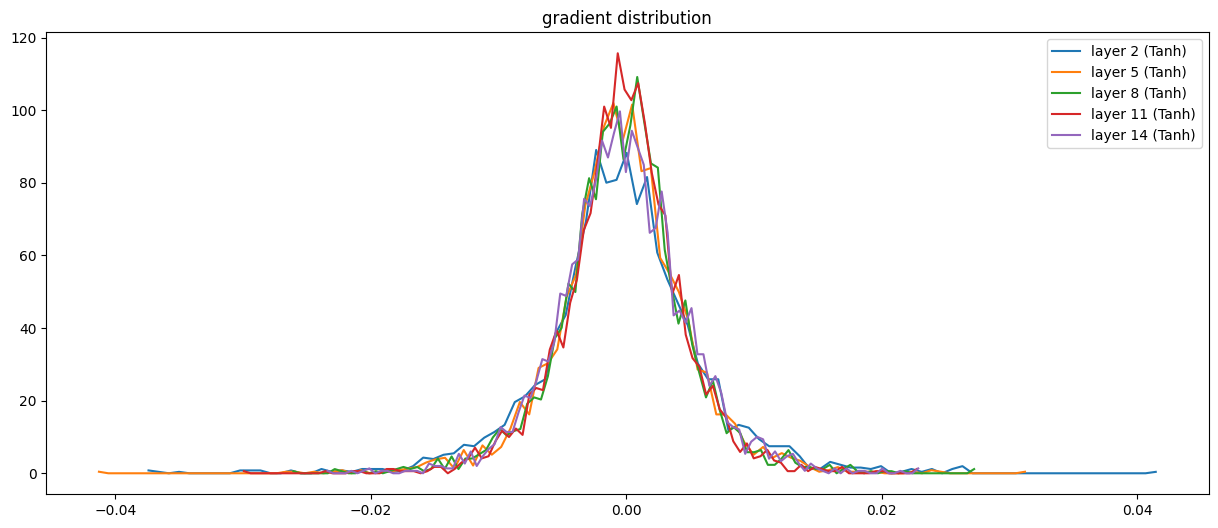

In [39]:
# gradient distirubtion
plt.figure(figsize=(15,6))
legends =[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__,t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title('gradient distribution');



weight   (27, 10) | mean +0.000000std 1.031187e-02 | grad:data ratio 8.678523e-03
weight  (50, 100) | mean -0.000019std 2.810032e-03 | grad:data ratio 2.782555e-03
weight (100, 100) | mean +0.000039std 1.864588e-03 | grad:data ratio 1.835893e-03
weight (100, 100) | mean -0.000002std 1.684407e-03 | grad:data ratio 1.661317e-03
weight (100, 100) | mean -0.000006std 1.521311e-03 | grad:data ratio 1.499508e-03
weight (100, 100) | mean +0.000004std 1.393107e-03 | grad:data ratio 1.398415e-03
weight  (100, 27) | mean +0.000009std 2.889333e-03 | grad:data ratio 2.810259e-03


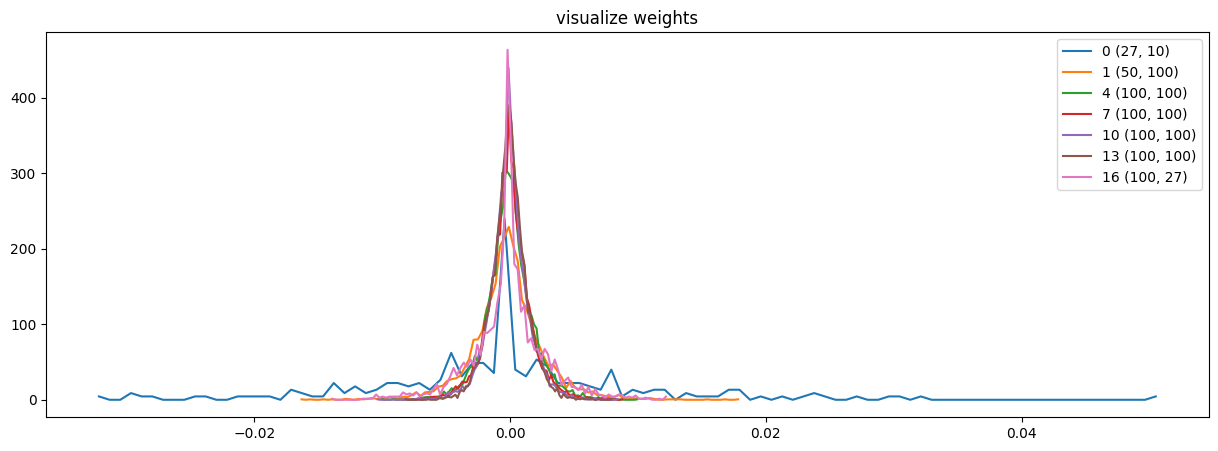

In [40]:
# visualize weights
plt.figure(figsize=(15,5))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+fstd %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f"{i} {tuple(p.shape)}")

plt.legend(legends);
plt.title("visualize weights");

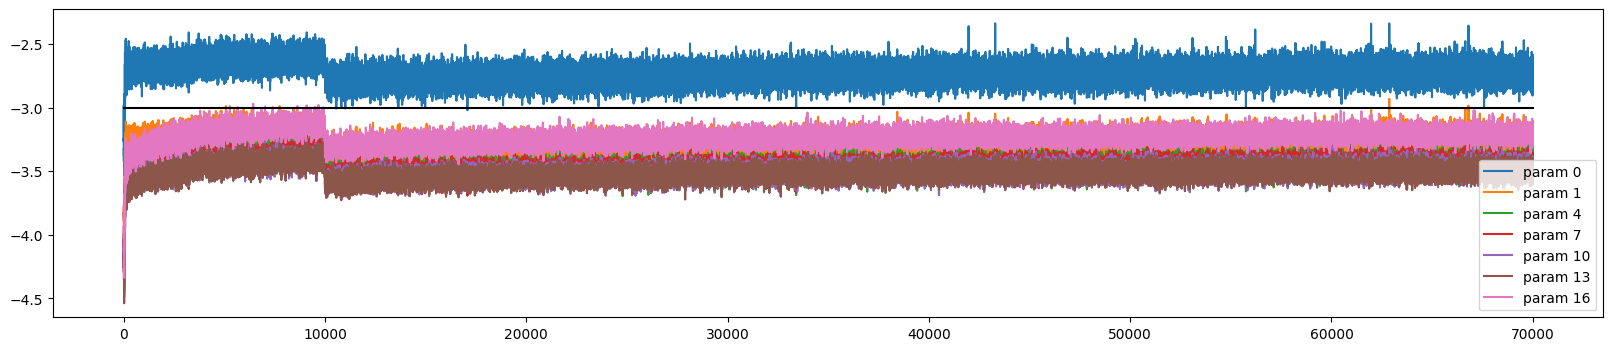

In [41]:
# plot update to data ratio

plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends);

Log₁₀ Ratio	Update/Weight Ratio	Behavior

| Log₁₀ Ratio      | Update/Weight Ratio | Behavior                      |
|------------------|---------------------|-------------------------------|
| `-2 to -4`       | 0.01 to 0.0001      | ✅ Healthy training range      |
| `> -2`           | > 1%                | ⚠️ Possibly too aggressive      |
| `< -4`           | < 0.01%             | ⚠️ May be too small to learn   |

In [48]:
checkpoint = torch.load('best_model.pth')
best_weights = checkpoint['weights']

@torch.no_grad()  #disable gradient tracking
def split_loss(split, parameters, best_weights):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for p, w in zip(parameters, best_weights):
        p.data = w.clone()
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train', parameters, best_weights)
split_loss('val', parameters, best_weights)

train 2.9532978534698486
val 2.9489872455596924


In [46]:
for _ in range(10):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(-1, n_embd * block_size)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = torch.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

ceanhlaoaytieiroa.
aatraeyaiaae.
aiaairriaezsyteeaalna.
i.
oautemca.
sleiraarmaaouleyaalalulezlirdjejeycaenauldeinierisveaoayelaabsbfaanyoenmayloec.
ahrtiiyeareqihuyalnznemeaeeeeacynsooaiitaaechdels.
cye.
.
aeeta.


#### 🚀 Track Update-to-Data Ratio Statistics for Each Parameter

In the training loop, we calculate the **update-to-data ratio** to monitor how significant each parameter update is relative to the parameter’s current scale. This is useful for diagnosing training stability and tuning learning rates.

- `p.grad.std()` → the standard deviation of the gradient  
  *Represents the size of the update.*

- `p.data.std()` → the standard deviation of the parameter values  
  *Represents the scale of the weights.*

- `lr * p.grad.std()` → the magnitude of the update  
  *Combines learning rate with gradient scale.*

- The ratio:
  
  ```python
  (lr * p.grad.std()) / p.data.std()
- `log10` -> This compresses the scale and makes it easier to visualize (since these ratios can span several orders of magnitude).